# Mini NeRF

## Introduction

Novel view synthesis an important problem in computer vision. It has a lot of applications such as video enhancement and virtual reality. *Neural Radiance Fields* (NeRFs) is a simple and powerful model for such kind of problem. It use the idea of **volume rendering** to train a model that implicitly contains the 3D information and samples from it to reconstruct the image. By encoding both position and viewing direction into the input, the NeRF model is able to "understand" the radiance distribution in the scene, thus reconstructing the image with better illumination details.

In this project, we reimplemented the NeRF method using pytorch and train it with smaller MLP and lower resolution images using only the "coarse" model so that it can quickly converge on smaller GPU.

## Setting up environments

In [1]:
# imports
import torch
import torch.nn.functional as F
import numpy as np
import sys
import os
from tqdm import tqdm
from matplotlib import pyplot as plt

# select device
DEVICE = None
if torch.cuda.is_available():
    print("Good to go!")
    DEVICE = torch.device("cuda")
else:
    print("Bad to go!")
    DEVICE = torch.device("cpu")
# load config files
sys.path.append(os.getcwd())
import configs.hotdog, configs.lego
dataset_configs:list = [configs.hotdog, configs.lego]

Good to go!


In [2]:
# hyper parameters for model
sample_t: tuple = (2,6) # t_n, t_f

# 100x100: scale_factor=3
# 200x200:scale_factor=2
scale_factor = 3

# dataset to use
config = configs.lego

## Dataset

We are using two scenes from the datasets of the NeRF paper: the lego model and the hotdog. These datasets are generated from Blender so that the ground truth intrinsic and extrinsic parameters are known. The images are resized to 100x100 for smaller GPU. 

Below are examples extracted from the dataset. We can see that the lego model contains many details while the hotdog model is simpler but contains rich illumination features.

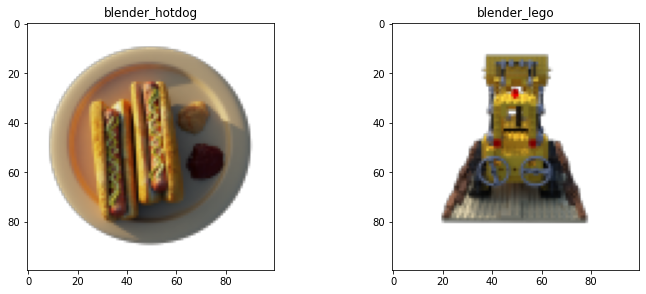

In [3]:
from nerf.data import load_blender
imgs_dict:dict = {}
poses_dict:dict = {}
int_mat_dict:dict = {}
demo_images: list = []
names: list = []
for data_config in dataset_configs:
    key:str = data_config.expname
    imgs_dict[key], poses_dict[key], int_mat_dict[key] = load_blender(data_config.datadir, device="cpu", scale_factor=scale_factor)
    demo_images.append(imgs_dict[key][0])
    names.append(data_config.expname)

# plot images
fig = plt.figure(figsize=(12,10))
columns = 2
for i, image in enumerate(demo_images):
    ax = plt.subplot(int(len(demo_images) / columns + 1), int(columns), i + 1)
    ax.title.set_text(names[i])
    plt.imshow(image)
plt.show()

# rename data for further usage
imgs, poses, int_mat = imgs_dict[config.expname], poses_dict[config.expname], int_mat_dict[config.expname]
img_h, img_w = imgs.shape[1:3]

## Method
In this section, we showed several functions used during training and inference, and tested them with fake data input.

### Ray Generation
This function generate a vector indicating a ray from each of the pixels of an image and transform them into the world coordinate using camera extrinsics.

In [4]:
# compute rays
from nerf.graphics import compute_rays

rays_o, rays_d = compute_rays((img_h, img_w), int_mat, poses[0])
print("origin: ", rays_o[0,0])
print("center of ray: ", rays_d[img_h//2,img_w//2])

origin:  tensor([-0.0538,  3.8455,  1.2081], dtype=torch.float64)
center of ray:  tensor([ 0.0133, -0.9539, -0.2997], dtype=torch.float64)


### Sampling from ray

This function generate samples from rays using the coarse sampling method described from the paper: divide the ray in a range to equally size bins, sample uniformly from each bin to get a set of sample points. For training time consideration, we did not implemented the fine model.

The test block extracted samples from one ray, we can see that the samples are distributed on a line.

In [5]:
from nerf.graphics import queries_from_rays
samples, depths = queries_from_rays(rays_o, rays_d, sample_t, 8)
print("samples[0, 0]: ", samples[0,0])
print("depths[0, 0]: ", depths[0,0])

samples[0, 0]:  tensor([[ 0.8590,  1.2718,  1.3147],
        [ 0.9844,  0.9183,  1.3293],
        [ 1.2806,  0.0833,  1.3639],
        [ 1.4457, -0.3822,  1.3832],
        [ 1.6929, -1.0794,  1.4120],
        [ 1.7938, -1.3637,  1.4238],
        [ 2.1053, -2.2421,  1.4602],
        [ 2.3522, -2.9381,  1.4890]], dtype=torch.float64)
depths[0, 0]:  tensor([2.4354, 2.7699, 3.5601, 4.0005, 4.6602, 4.9292, 5.7605, 6.4191],
       dtype=torch.float64)


### Positional Encoding

The author of the paper found that the model will be very hard to converge if the positions and directions are passed directly into the model. Therefore, a encoding function is needed to map the input to higher dimension space.

In [6]:
from nerf.nerf_helper import PosEncode

L = 6
x = torch.tensor([[ 1.8013, -0.6242,  0.7009]])
enc_x = PosEncode(x, L, True)
print(enc_x)

tensor([[ 1.8013,  0.9736, -0.2285, -0.4449, -0.8956,  0.7968,  0.6042,  0.9629,
         -0.2698, -0.5197, -0.8544,  0.8880,  0.4599, -0.6242, -0.5844,  0.8114,
         -0.9485,  0.3168, -0.6010, -0.7992,  0.9607,  0.2775,  0.5332, -0.8460,
         -0.9022,  0.4313,  0.7009,  0.6449,  0.7643,  0.9858,  0.1682,  0.3316,
         -0.9434, -0.6257,  0.7801, -0.9762,  0.2171, -0.4238, -0.9057]])


### Rendering
The NeRF model will output the rgb values and the volume densities at the sampled points. A rendering function is needed to combine these results together and calculate the final rgbd value displaying on the pixel.

The testing block use the original training image as an fake output of the MLP and the render function successfully recovered the image.

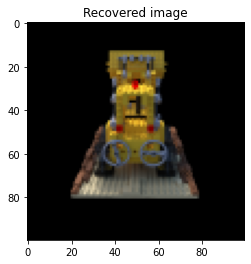

In [7]:
from nerf.graphics import render_from_nerf
fake_depth = torch.Tensor([1])
fake_nerf_output = imgs[0].cpu().reshape(img_h, img_w, 1, 4)
rgb, depth = render_from_nerf(fake_nerf_output, fake_depth)
plt.imshow(rgb)
plt.title("Recovered image")
plt.show()

### Generating poses
This function is used when we want to view the model from a new perspective (pose).

In [8]:
from nerf.graphics import generate_demo_poses
demo_poses = generate_demo_poses()
print(demo_poses.shape)
print(demo_poses[0])

torch.Size([40, 4, 4])
tensor([[-1.0000e+00, -6.1232e-17,  1.0606e-16,  4.2423e-16],
        [-1.2246e-16,  5.0000e-01, -8.6603e-01, -3.4641e+00],
        [ 0.0000e+00,  8.6603e-01,  5.0000e-01,  2.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])


## Experiment
In this section we will show a demo process of training and compare the pretrained models.

### Model
We modified the model in original paper for faster convergence.

The depth of the fully-connected model is set to 4 instead of 8 in original paper, and skip connection occurs in the second layer instead of the 4th layer.
The umber of points sampled from a ray is set to 128.

We trained for 10000 iterations with a batch size of 8192.



### Training Demo
Here, we provide the training code with a demo run. The performance should be far worse than our experiment results.

The parameters are modified to fit basic GPUs:
- `num_samples` = 32
- `num_it` = 1000

In [9]:
from nerf.model import NeRF 
import os.path

# seed = 9458
# torch.manual_seed(seed)
# np.random.seed(seed)
###### hyper-parameters
L_pos = 10
L_dir = 4
num_samples = 32
batch_size = 8192 # increase batchsize if u have large GPU MEM
fc_width = 128
fc_depth = 4
skips = [2]
lr = 5e-4
num_it = 1000
display_every = 200

###### models
model = NeRF(ch_in_pos=6*L_pos+3, ch_in_dir=6*L_dir+3, fc_width=fc_width, fc_depth=fc_depth, skips=skips)
model.to(DEVICE)

###### load validation data
imgs_val, poses_val, _ = load_blender(config.datadir, data_type="val",scale_factor=scale_factor, device="cpu")
num_val = imgs_val.shape[0]

###### train
psnrs = []
val_its = []
losses = []
i = 0

###### optimizer, checkpoint
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=lr)

In [9]:
###### check saved checkpoints
ckpt_path = 'nerf.pt'
if os.path.exists(ckpt_path):
    print("checkpoint found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    losses = checkpoint['losses']
    psnrs = checkpoint['psnrs']
    val_its = checkpoint['its']
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")

No checkpoint found


  0%|          | 0/1000 [00:00<?, ?it/s]

Iteration  0
Val loss:  0.09182982352816041


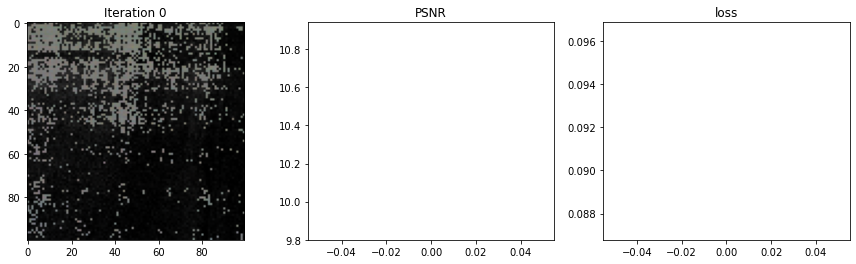

 20%|██        | 200/1000 [03:11<12:51,  1.04it/s]

Iteration  200
Val loss:  0.020090257710428293


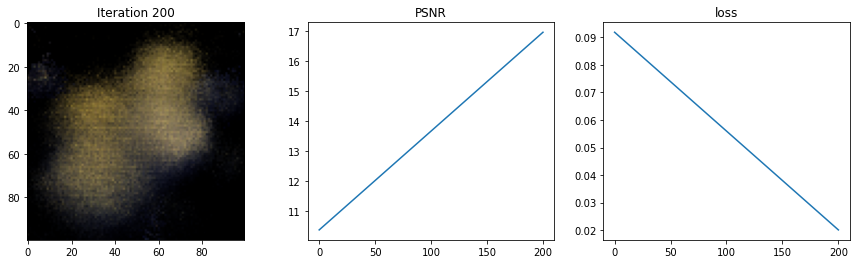

 40%|████      | 400/1000 [06:23<09:38,  1.04it/s]

Iteration  400
Val loss:  0.008198410278635783


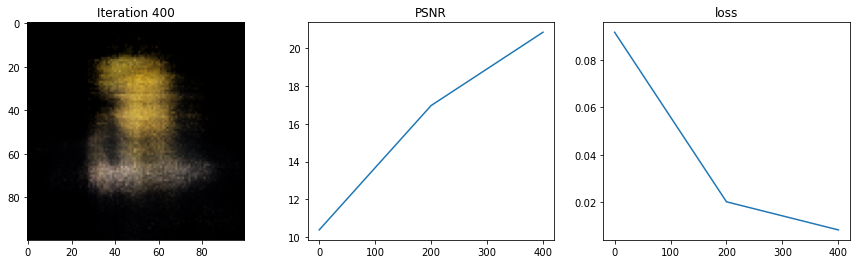

 60%|██████    | 600/1000 [09:36<06:25,  1.04it/s]

Iteration  600
Val loss:  0.01563695181567076


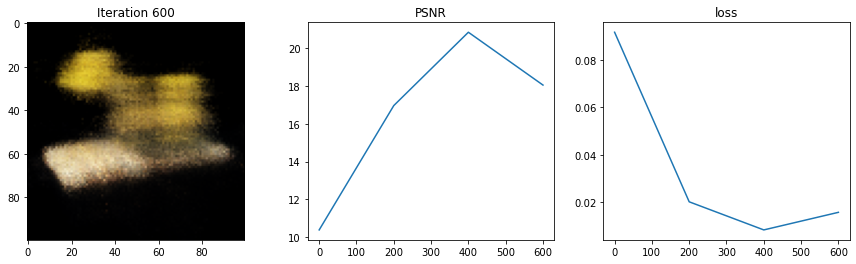

 80%|████████  | 800/1000 [12:48<03:12,  1.04it/s]

Iteration  800
Val loss:  0.01147625637673688


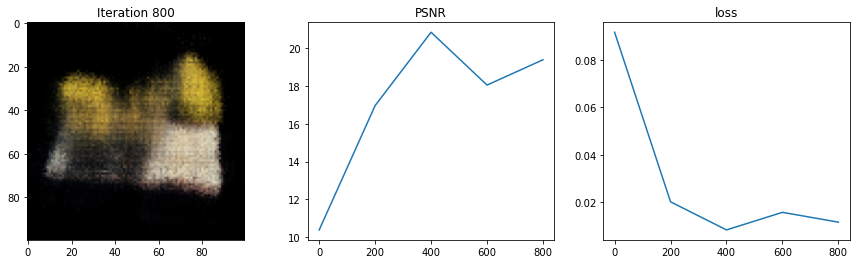

100%|██████████| 1000/1000 [16:01<00:00,  1.04it/s]


In [10]:
# start training
from nerf.training_logic import train_NeRF
train_NeRF(model = model, optimizer=optimizer,imgs_train=imgs, imgs_val=imgs_val, poses_train=poses, poses_val=poses_val,int_mat=int_mat, sample_t=sample_t,
            L_pos=L_pos, L_dir=L_dir, num_samples=num_samples, ckpt_path=ckpt_path, batch_size=batch_size,
            psnrs=psnrs, val_its=val_its, losses=losses, start_iter_num=i, end_iter_num=num_it, val_gap=display_every)

### Train Result
Our entire training plots are provided below. 

#### Hotdog Scenario
![](./media/hotdog_train.png)

#### Lego Scenario
Sample number 32, 200x200 resolution:

![](./media/lego_train_numsample%3D32.png)

Sample number 128, 100x100 resolution:

![](./media/lego_train_numsample%3D128.png)


We can see that the plot with greater sample number (the later one) exhibits finer details though having lower resolution.

### Inference and generate video
After training we can generate a demo video using generated pose.

In [14]:
from torch import Tensor
from nerf.nerf_helper import nerf_iter_once
import cv2
import imageio
# generate pose
model.eval()
gen_num: int = 120
repeat: int = 2
gen_poses:Tensor = generate_demo_poses(height=4, num_poses=gen_num).to(poses).to(DEVICE)
gen_imgs:list = []
for i in range(gen_num):
    with torch.no_grad():
        pred_rgb, pred_depth = nerf_iter_once(
                model,
                (img_h, img_w),
                int_mat.to(DEVICE),
                gen_poses[i],
                sample_t,
                L_pos,
                L_dir,
                num_samples=num_samples,
                batch_size=batch_size
                )
    # concat channels
    pred_rgbd: Tensor = torch.cat([pred_rgb, pred_depth[...,None]], dim=-1)
    # translate to [0,255]
    img_np = np.array(pred_rgbd.detach().cpu()*255).astype(np.uint8)
    img_np = cv2.resize(img_np, (112,112), interpolation=cv2.INTER_AREA)
    gen_imgs.append(img_np)

gen_imgs = gen_imgs * repeat

demo_video_path: str = "media/{}_demo.mp4".format(config.expname)
imageio.mimwrite(demo_video_path, gen_imgs, fps=30, quality=8)

Videos generated using our trained model are shown below.

In [15]:
from ipywidgets import Video
video = Video.from_file("./media/blender_hotdog.mp4")
video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x03\x8eYmdat\x00\x…

In [16]:
video = Video.from_file("./media/blender_paper_lego_100x100.mp4")
video

Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x05\xdf\xa6mdat\x0…

### Test and Comparison
We perform inference based on the poses of the test images and compare the results with the ground truth. The results are shown below.

lego_100x100 on testdata:
PSNR:  21.04780462691312
SSIM:  0.7853995665673306

Hotdog on test dataset:
PSNR:  29.81981982968555
SSIM:  0.9356882317837466


The results show that our model perform worse than the model in the paper.

In [19]:
import pytorch_msssim
from nerf.nerf_helper import nerf_iter_once
def test():
    psnr_ = 0
    ssim_ = 0
    for i in range(num_test):
        test_idx = i
        test_img = imgs_test[test_idx].clone().to(DEVICE)
        test_c2w = poses_test[test_idx].clone().to(DEVICE)

        pred_rgb, _ = nerf_iter_once(
                    model,
                    (img_h, img_w),
                    int_mat_test.to(DEVICE),
                    test_c2w,
                    sample_t,
                    L_pos,
                    L_dir,
                    num_samples=num_samples,
                    batch_size=batch_size
                )
        loss = torch.nn.functional.mse_loss(pred_rgb, test_img[..., :3])

        psnr_ += float(-10. * torch.log10(loss))
        
        ssim_val = pytorch_msssim.ssim(pred_rgb.permute(2,0,1).reshape(1,3,100,100), test_img[..., :3].permute(2,0,1).reshape(1,3,100,100), data_range=1)
        ssim_ += float(ssim_val)

    psnr_ /= num_test
    ssim_ /= num_test

    print("PSNR: ", psnr_)
    print("SSIM: ", ssim_)

ckpt_path = './trained_models/basic_nerf_lego_10000_100x100.pt'
print("checkpoint path: ", ckpt_path)
if os.path.exists(ckpt_path):
    print("checkpoint found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    loss = checkpoint['loss']
    psnrs = checkpoint['psnrs']
    val_its = checkpoint['its']
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")

model.eval()
imgs_test, poses_test, int_mat_test = load_blender(config.datadir, data_type="test",scale_factor=scale_factor, device="cpu")
num_test = imgs_test.shape[0]

with torch.no_grad():
    test()

checkpoint path:  ./trained_models/basic_nerf_lego_10000_100x100.pt
checkpoint found! Loading...
checkpoint loaded, i = 10000
PSNR:  21.04780462691312
SSIM:  0.7853995665673306


Compare demo results with ground truth image

./trained_models/basic_nerf_lego_10000_100x100.pt found! Loading...
checkpoint loaded, i = 10000


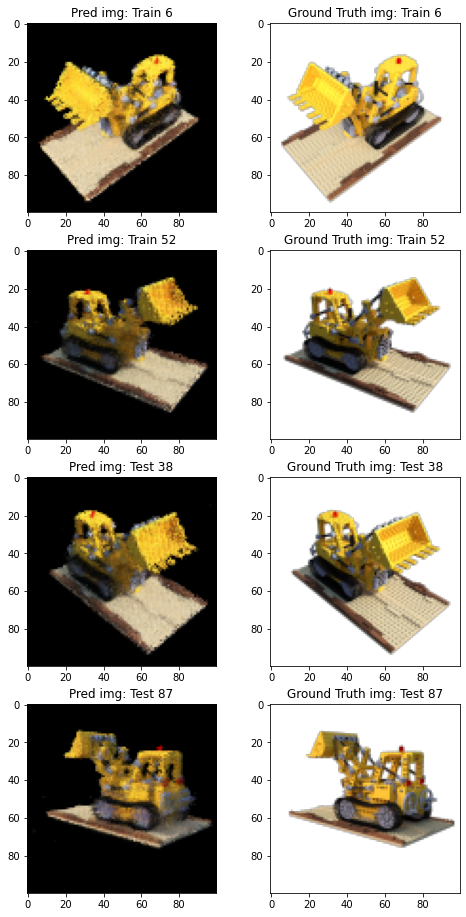

In [11]:
from nerf.nerf_helper import compare
data_pac:dict = {
        "imgs": imgs,
        "poses": poses,
        "DEVICE": DEVICE,
        "config": config,
        "scale_factor": scale_factor,
        "sample_t": sample_t,
        "num_samples": 64,
        "batch_size": batch_size,
        "model": model,
        "L_pos": L_pos,
        "L_dir": L_dir,
}
ckpt_path = './trained_models/basic_nerf_lego_10000_100x100.pt'
if os.path.exists(ckpt_path):
    print(ckpt_path, "found! Loading...")
    checkpoint = torch.load(ckpt_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    i = checkpoint['epoch']
    loss = checkpoint['loss']
    psnrs = checkpoint['psnrs']
    its = checkpoint['its']
    model.eval()
    print("checkpoint loaded, i =",i)
else:
    print("No checkpoint found")
    
with torch.no_grad():
    compare(**data_pac)

Figures shown below are comparison of two scenarios generated using `num_samples` = 128 during our experiment.

![Lego](./media/lego_cmp.png)
![HOtdog](./media/hotdog_cmp.png)

### Conclusion

In this project, we've reimplemented the basic functionality of NeRF in pyTorch, applied it to two scenarios and done both quantitively and qualitative analysis on the result.



The major shortcoming of this project is the lack of hierarchical sampling and the much lower resolution we select.  If given more time and computation resources, we would consider to fully reimplement NeRF, train it with standard resolution, and even try something more interesting, like [NeRF without Neural Networks](https://alexyu.net/plenoxels/).